# Tutorial 1. Space model API and simple generator
### **NOTE!** This guide is written for NNDT v0.0.0. We are working on API improvements every day.

The vast majority of libraries for data science are written with the concept of separating data from processing methods. This allows researchers to easily work in the data pipeline paradigm. However, working with 3D objects this way is a bad idea for several reasons.
1. You can easily look at image, text, or table, but mesh analysis requires additional software and call methods to check the data consistency.
2. Each row or column in tabular data is almost independent. In a 3D scene, all objects affect each other. For example, two objects may overlap, breaking data consistency and correctness.
3. Tables and images, do not require high-performance representation. Precalculation of KDTree, BoxTree, or implicit representation crucially improves the performance of requests for the 3D object.
4. If your code uses a physically informed neural network, you must keep physical units and recalculate them properly, in other cases the obtained result may be wrong.

All these restrictions encouraged us to implement another approach to data loading in NNDT. 

This guide is about a **space model**, which is a key feature of the NNDT library. 

The space model is a virtual scene with several 3D objects. It analyses the structure of the data received and offers all the available data loaders and data samplers that are applicable to this exact data. In other words, **if a function is provided, it will work with your data with no problems**. Functions are basically blocks that help you to build data generators. 

---



---



Let's install NNDT package and download some data needed for the experiments first.

In [1]:
# Install NNDT
!pip install git+https://github.com/KonstantinUshenin/nndt.git@v0.0.1rc
# Download sample data
!wget https://github.com/KonstantinUshenin/nndt/raw/main/tests/acdc_for_test.7z
!7z x acdc_for_test.7z

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/KonstantinUshenin/nndt.git (to revision v0.0.1rc) to /tmp/pip-req-build-_1kic1fl
  Running command git clone -q https://github.com/KonstantinUshenin/nndt.git /tmp/pip-req-build-_1kic1fl
  Running command git checkout -b v0.0.1rc --track origin/v0.0.1rc
  Switched to a new branch 'v0.0.1rc'
  Branch 'v0.0.1rc' set up to track remote branch 'v0.0.1rc' from 'origin'.
     |████████████████████████████████| 41 kB 505 kB/s 
     |████████████████████████████████| 342 kB 7.1 MB/s 
     |████████████████████████████████| 145 kB 61.6 MB/s 
     |████████████████████████████████| 88.3 MB 94 kB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
  Created wheel for NNDT: filename=NNDT-0.0.0-py3-none-any.whl size=21854 sha256=a35fd381751d735dcaecef9255e9943066d3d2042581ff68b069e46271361edc
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p1ki_6k/wheels/81/b4/69/

We need `os` to iterate over files in a directory, and simple data `loaders` from the NNDT.

In [2]:
import os

import jax.numpy as jnp
from nndt.space.loaders import load_data, preload_all_possible

Let's look at the data we've just downloaded. The following figure shows how these objects looks at Paraview.
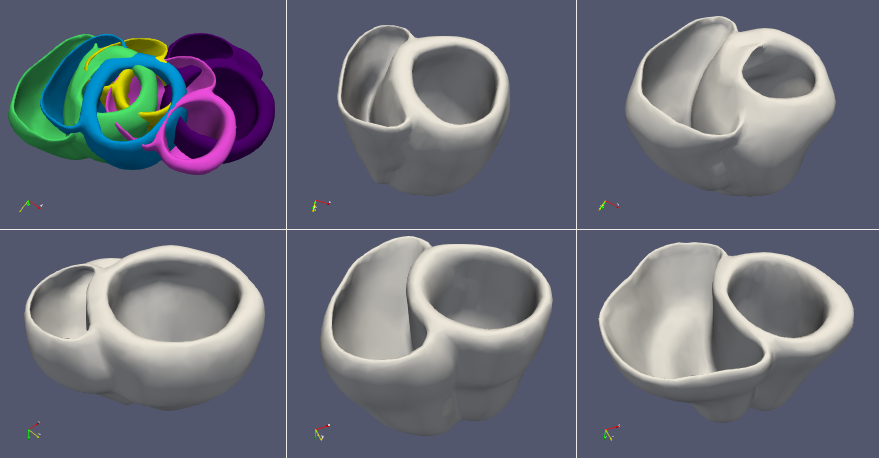


Now we iterate over the files we need and upload them into memory. 

In [3]:
name_list = os.listdir('./acdc_for_test')
name_list.sort()
mesh_list = [f"./acdc_for_test/{p}/colored.obj" for p in name_list]
sdt_list = [f"./acdc_for_test/{p}/sdf.npy" for p in name_list]

print(name_list)
print(mesh_list)
print(sdt_list)

['patient009', 'patient029', 'patient049', 'patient069', 'patient089']
['./acdc_for_test/patient009/colored.obj', './acdc_for_test/patient029/colored.obj', './acdc_for_test/patient049/colored.obj', './acdc_for_test/patient069/colored.obj', './acdc_for_test/patient089/colored.obj']
['./acdc_for_test/patient009/sdf.npy', './acdc_for_test/patient029/sdf.npy', './acdc_for_test/patient049/sdf.npy', './acdc_for_test/patient069/sdf.npy', './acdc_for_test/patient089/sdf.npy']


Now we create our `Space model`. 

Below you see its structure and different tree node types that we use:
1. Space `main` is a tree root.
2. Group `default` is a basic group for data. If your call `load_data` with `test_size=XXXX`, the method creates `test` and `train` groups with the given percent of cases in the test group.
3. 'Object' is an abstract representation of something in 3D space. An object may be presented by multiple files, configs, etc. The major role of the Object node in this tree is to be a clear mark which indicates that some pieces of data should be processed as a whole.
4. MeshSource, SDTSource is nothing but the location of some files.

When `load_data` constructs a space model, it checks the existence of files, but it doesn't check the consistency of data in it.

In [4]:
space = load_data(name_list, mesh_list, sdt_list)
print(space.explore())

Space("main", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
└── Group("default", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
    ├── Object("patient009", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
    │   ├── MeshSource("mesh", filename="colored.obj")
    │   └── SDTSource("sdt", filename="sdf.npy")
    ├── Object("patient029", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
    │   ├── MeshSource("mesh", filename="colored.obj")
    │   └── SDTSource("sdt", filename="sdf.npy")
    ├── Object("patient049", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
    │   ├── MeshSource("mesh", filename="colored.obj")
    │   └── SDTSource("sdt", filename="sdf.npy")
    ├── Object("patient069", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
    │   ├── MeshSource("mesh", filename="colored.obj")
    │   └── SDTSource("sdt", filename="sdf.npy")
    └── Object("patient089", bbox="((0.00, 0.00, 0.00), (0.00, 0.00, 0.00))")
        ├── MeshSource("mesh", filename="colored.obj")
      

`preload_all_possible` is a magic method, that tries to load each file once. If data looks good, it creates some methods in the space model to sample this data or to do some data transformation. Note, that the method unloads all data from memory after processing, but does not call the garbage collector directly.

After the data is uploaded, this method provides **all the methods available for your data processing**, they are shown in MeshSource and SDTSource. If a method doesn't work on the presented data, the method is not provided.

In [5]:
preload_all_possible(space)
print(space.explore())

Space("main", bbox="((-0.95, -0.97, -0.97), (0.95, 0.97, 0.97))")
├── Group("default", bbox="((-0.95, -0.97, -0.97), (0.95, 0.97, 0.97))")
│   ├── Object("patient009", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
│   │   ├── MeshSource("mesh", filename="colored.obj")
│   │   │   └── MeshRepr("repr", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
│   │   │       ├── index2xyz(ns_index[1]) -> ns_xyz[3]
│   │   │       ├── sampling_eachN(count=N, step=1, shift=0) -> (ns_index[N], ns_xyz[N])
│   │   │       ├── save_mesh(filepath, dict)
│   │   │       ├── PointColorRepr("point_color")
│   │   │       ├── sampling_grid(spacing=(D,H,W)) -> xyz[D,H,W,3]
│   │   │       ├── sampling_uniform(N) -> xyz[N,3]
│   │   │       └── sampling_grid_with_shackle(N) -> xyz[N,3]
│   │   ├── SDTSource("sdt", filename="sdf.npy")
│   │   │   └── SDTRepr("repr", bbox="((-0.94, -0.90, -0.90), (0.94, 0.90, 0.90))")
│   │   │       ├── xyz2sdt(ns_xyz[...,3]) -> ns_sdt[...,1]
│   │   │       ├── xyz2l

The call of `preload_all_possible` loads all available data into memory once. For data consistency, this method recalculates the boundary boxes for each object. The following code shows this.

In [6]:
print(space['default']._bbox)
print(space['default/patient009']._bbox, space['default/patient029']._bbox)

((-0.9522853851318359, -0.96994, -0.96994), (0.9522853851318359, 0.9699400000000002, 0.9699400000000002))
((-0.9467665481567383, -0.9056295013427734, -0.9056295013427734), (0.9467665481567383, 0.9056295013427734, 0.9056295013427734)) ((-0.9441697311401367, -0.96994, -0.96994), (0.9441697311401367, 0.9699400000000002, 0.9699400000000002))


Yor can use `.explore()` for observe tree elements.

`mesh/repr` is a representation of objects as a mesh. It provides access to mesh points and cells.

In [7]:
print(space['default/patient009/mesh/repr'].explore())

MeshRepr("repr", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
├── index2xyz(ns_index[1]) -> ns_xyz[3]
├── sampling_eachN(count=N, step=1, shift=0) -> (ns_index[N], ns_xyz[N])
├── save_mesh(filepath, dict)
├── PointColorRepr("point_color")
├── sampling_grid(spacing=(D,H,W)) -> xyz[D,H,W,3]
├── sampling_uniform(N) -> xyz[N,3]
└── sampling_grid_with_shackle(N) -> xyz[N,3]


`sampling_eachN` provides indexes and positions of mesh points. The following code loads the first 10 points from the file.


In [8]:
index, xyz = space['default/patient009/mesh/repr/sampling_eachN'](10)
print(index)
print(xyz)

[0 1 2 3 4 5 6 7 8 9]
[[-0.7462251  -0.00697418 -0.6882663 ]
 [-0.74676657  0.00857941 -0.63459843]
 [-0.73795503  0.09239472 -0.7150549 ]
 [-0.7425813   0.12344483 -0.6429312 ]
 [-0.7460521   0.10270295 -0.67918694]
 [-0.73231244  0.17785889 -0.6847327 ]
 [-0.716128   -0.1617276  -0.7172235 ]
 [-0.72332454 -0.1835019  -0.6543213 ]
 [-0.72207695 -0.14731324 -0.60736024]
 [-0.7231009  -0.11507843 -0.7168824 ]]


`sdt/repr` is an additional file that includes precomputed signed distance tensors (SDT). It provides access to fast (O(1)) computation of distance from a point to a mesh.

In [9]:
print(space['default/patient009/sdt/repr'].explore())

SDTRepr("repr", bbox="((-0.94, -0.90, -0.90), (0.94, 0.90, 0.90))")
├── xyz2sdt(ns_xyz[...,3]) -> ns_sdt[...,1]
├── xyz2local_sdt(ns_xyz[3], spacing=(D,H,W), scale=1.) -> ns_xyz[D,H,W,3], ns_local_sdt[D,H,W,1]
├── sampling_grid(spacing=(D,H,W)) -> xyz[D,H,W,3]
├── sampling_uniform(N) -> xyz[N,3]
└── sampling_grid_with_shackle(N) -> xyz[N,3]


The following code convert array of points in 3D space to an array of distances to the proper mesh.

In [10]:
space['default/patient009/sdt/repr/xyz2sdt'](jnp.array([[0.,0.,0.], [1.,1.,1.]]))

array([[0.29051676],
       [0.9393615 ]], dtype=float32)

To sum up everything, let's write a simple data generator with three basic methods.

`__init__` loads data and creates a space model

`__len__` returns the lenght of our generator

 `__getitem__` includes grid sampling of 1000 points from the whole scene and conversion of the coordinates to the SDT. Other codes are described above in this notebook.

In [11]:
class SimpleGenerator:

  def __init__(self, folder, spacing=(10,10,10)):
    self.spacing = spacing


    self.name_list = os.listdir(folder)
    self.name_list.sort()
    self.mesh_list = [f"{folder}/{p}/colored.obj" for p in name_list]
    self.sdt_list = [f"{folder}/{p}/sdf.npy" for p in name_list]
    self.space = load_data(self.name_list, self.mesh_list, self.sdt_list)
    preload_all_possible(self.space)

  def __len__(self):
    return len(self.name_list)

  def __getitem__(self, index):
    cube_xyz = space['default/sampling_grid'](spacing=self.spacing)
    cube_sdt = space[f'default/{self.name_list[index]}/sdt/repr/xyz2sdt'](cube_xyz)
    return cube_xyz, cube_sdt

Let's run the generator.

In [12]:
sg = SimpleGenerator('./acdc_for_test')
len(sg)

5

In [13]:
for xyz, sdt in sg:
  print(xyz.shape, sdt.shape)

(10, 10, 10, 3) (10, 10, 10, 1)
(10, 10, 10, 3) (10, 10, 10, 1)
(10, 10, 10, 3) (10, 10, 10, 1)
(10, 10, 10, 3) (10, 10, 10, 1)
(10, 10, 10, 3) (10, 10, 10, 1)


**Known issues:**
 - `preload_all_possible` may fail if something bad happens inside the VTK library;
 - `space['X/XX/XXX']` syntax is not suitable for IDE spell checkers and Jupiter notebook auto substitution. 
 - documentation for space model functions is not ready yet.
 - SDTRepr cannot support big scenes and provide wrong values if requested points are located too far.

We are hardly working on fixes for these issues!